Classification Models for ifood-data-business-analyst-test-latam-main

By: Alejandro Rojas Benítez
https://www.linkedin.com/in/arojasb3/

this module works with the standard anaconda package except imbalanced-learn

It will need the command pip install imbalanced-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df2 = pd.read_csv('not_scaled_data_with_clusters.csv')
df_scaled = pd.read_csv('scaled_data_with_clusters.csv')

In [3]:
# numerical variables we will take into account
numerical_cols = [ 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                 'age', 'enrollment_time', 'clusters_kmeans']

# categorical variables we will take into account. We will ignore Complain since it is too unbalanced
categorical_cols = ['Education', 'Marital_Status']

# campaigns for cluster analysis
campaings = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

In [4]:
random_state = 42

In [5]:
# Create a new dataset where categorical variables are dummies
X = pd.get_dummies(df_scaled[numerical_cols + categorical_cols + campaings[:-1]])

X = pd.get_dummies(X, columns=[ 'clusters_kmeans'])
X.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,clusters_kmeans_0,clusters_kmeans_1,clusters_kmeans_2,clusters_kmeans_3
0,0.516867,0.0,0.0,0.585859,0.425318,0.442211,0.554878,0.664093,0.444444,0.353414,...,0,0,0,1,0,0,1,0,0,0
1,0.396485,0.5,0.5,0.383838,0.007368,0.005025,0.006098,0.007722,0.005051,0.024096,...,0,0,0,1,0,0,0,1,0,0
2,0.654408,0.0,0.0,0.262626,0.285332,0.246231,0.129065,0.428571,0.106061,0.168675,...,0,0,0,0,1,0,1,0,0,0
3,0.195425,0.5,0.0,0.262626,0.007368,0.020101,0.020325,0.038610,0.015152,0.020080,...,0,0,0,0,1,0,0,0,1,0
4,0.518449,0.5,0.0,0.949495,0.115874,0.216080,0.119919,0.177606,0.136364,0.060241,...,1,0,1,0,0,0,0,0,1,0


In [6]:
y = df_scaled['Response']

In [7]:
# undersampling thanks to https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state = random_state)

X_under, y_under= undersample.fit_resample(X, y)

In [8]:
X_under.shape, X.shape

((990, 36), (2185, 36))

In [9]:
y_under.value_counts()

0    660
1    330
Name: Response, dtype: int64

In [10]:
# split dataset into 60% 20% 20%
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

In [11]:
# logistic regression parameters set
regularization = np.linspace(0.01, 1, 100)

In [12]:
# finding best regularization for our logistic regression
prev_f1 = 0
logistic = None
for C in regularization:
    clf = LogisticRegression(random_state=random_state, C = C)
    clf.fit(X_train, y_train)
    curr_f1 = f1_score(clf.predict(X_val), y_val, average='binary')
    
    if prev_f1 < curr_f1:
        prev_f1 = curr_f1
        logistic = clf

In [13]:
# validation set f1
prev_f1

0.7130434782608696

In [14]:
accuracy_score(logistic.predict(X_test), y_test)

0.797979797979798

In [15]:
recall_score(logistic.predict(X_test), y_test)

0.7735849056603774

In [16]:
f1_score(logistic.predict(X_test), y_test, average='binary')

0.6721311475409837

In [17]:
models_coefficients = pd.DataFrame(logistic.coef_[0], X_train.columns, columns = ['log_coefficients'])

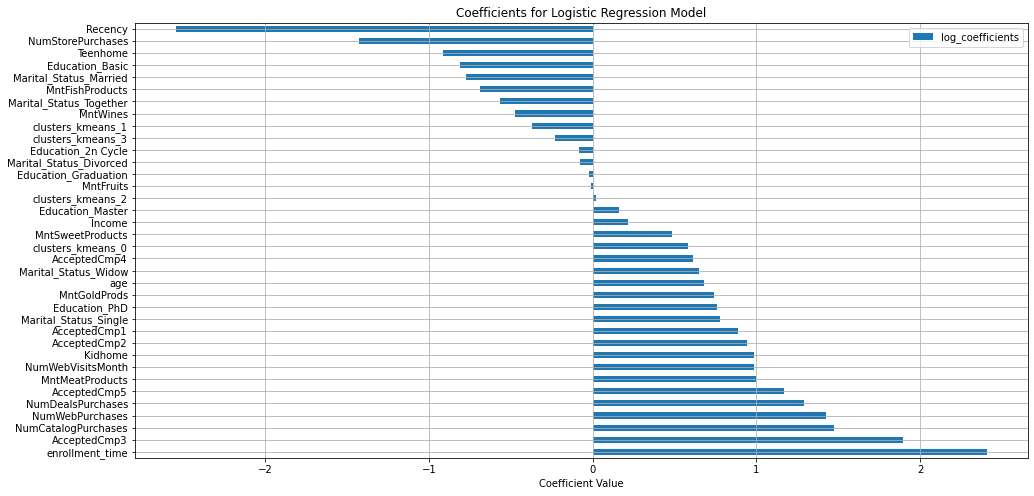

In [18]:
ax = models_coefficients.sort_values(by='log_coefficients',ascending=False).plot(kind='barh', figsize=(16,8), grid=True, title='Coefficients for Logistic Regression Model')

ax.set_xlabel('Coefficient Value');

In [19]:
# Random Forest parameters

number_of_trees = range(100, 151)

depths = range(2, len(X.columns))

In [20]:
# finding best regularization for our logistic regression
prev_f1_rf = 0
rf = None
for trees, depth in zip(number_of_trees, depths):
    clf = RandomForestClassifier(n_estimators=trees, max_depth=depth, random_state=random_state)
    clf.fit(X_train, y_train)
    curr_f1 = f1_score(clf.predict(X_val), y_val, average='binary')
    
    if prev_f1_rf < curr_f1:
        prev_f1_rf = curr_f1
        rf = clf

In [21]:
# validation set f1
prev_f1_rf

0.7068965517241379

In [22]:
accuracy_score(rf.predict(X_test), y_test)

0.7474747474747475

In [27]:
recall_score(rf.predict(X_test), y_test)

0.6557377049180327

In [23]:
f1_score(rf.predict(X_test), y_test, average='binary')

0.6153846153846154

In [24]:
models_coefficients_rf = pd.DataFrame(rf.feature_importances_, X_train.columns, columns = ['rf_coefficients'])

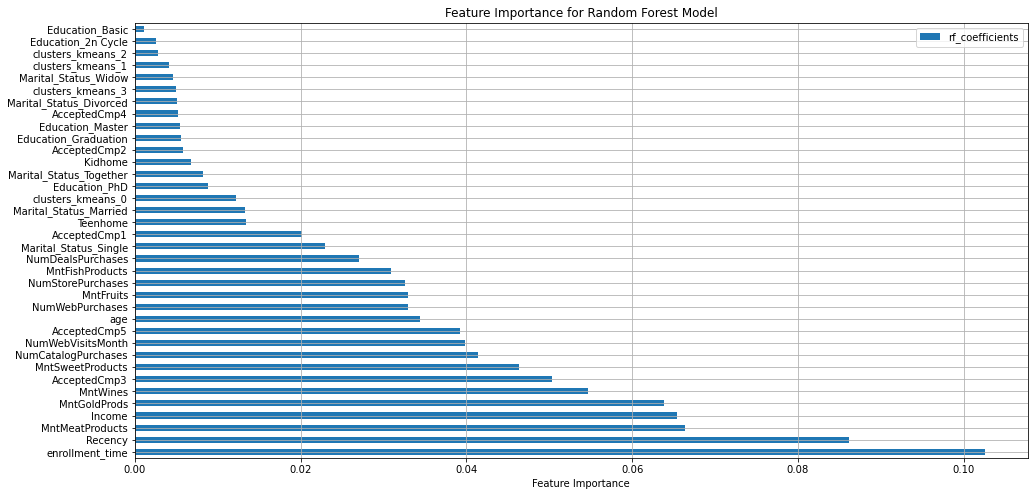

In [25]:
ax = models_coefficients_rf.sort_values(by='rf_coefficients',ascending=False).plot(kind='barh', figsize=(16,8), grid=True, title='Feature Importance for Random Forest Model')

ax.set_xlabel('Feature Importance');

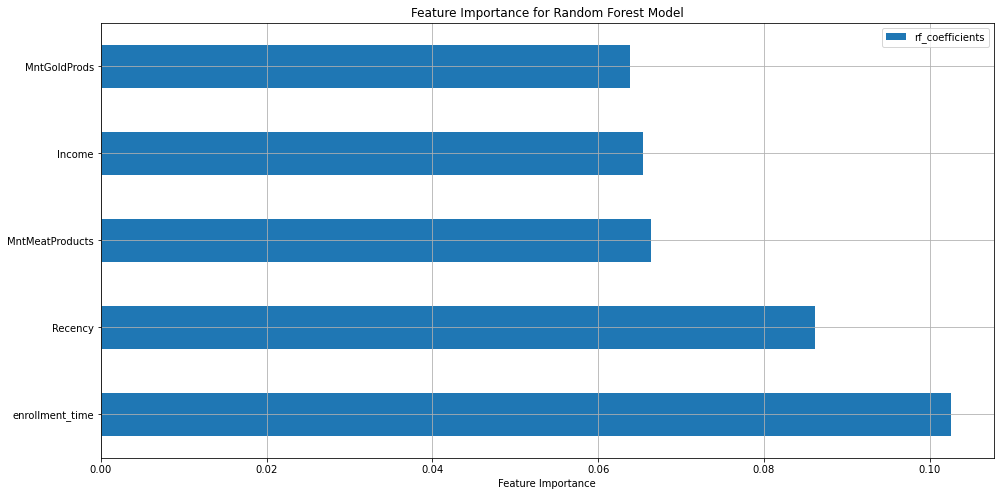

In [26]:
ax = models_coefficients_rf.nlargest(5, 'rf_coefficients').plot(kind='barh', figsize=(16,8), grid=True, title='Feature Importance for Random Forest Model')

ax.set_xlabel('Feature Importance');